<a href="https://colab.research.google.com/github/MDAyesha/DR-Detection-using-DL/blob/main/DR_detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diabetic Retinopathy Detection using Deep Learning on Fundus Images

1. Load the Dataset

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
image_dir = Path('/content/drive/MyDrive/DR dataset/gaussian_filtered_images')
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(5)

Filepath           Label
0  /content/drive/MyDrive/DR dataset/gaussian_fil...           No_DR
1  /content/drive/MyDrive/DR dataset/gaussian_fil...  Proliferate_DR
2  /content/drive/MyDrive/DR dataset/gaussian_fil...           No_DR
3  /content/drive/MyDrive/DR dataset/gaussian_fil...        Moderate
4  /content/drive/MyDrive/DR dataset/gaussian_fil...        Moderate

In [ ]:
image_df.shape

(3689, 2)

2. Visualization of Dataset

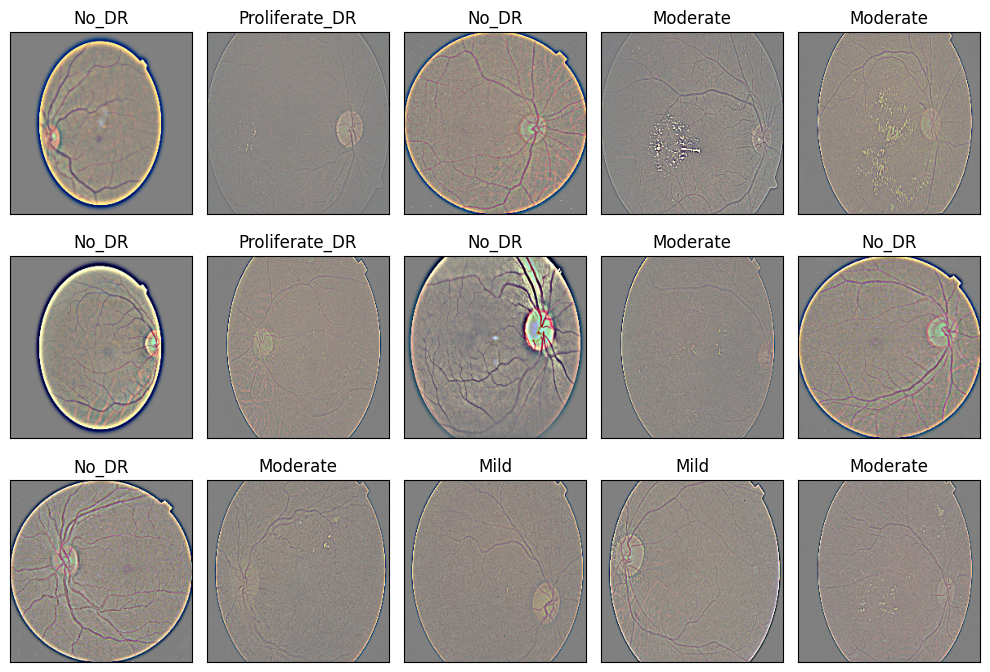

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-6-abc965a80a52>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = count.index, y = count, palette = "rocket")


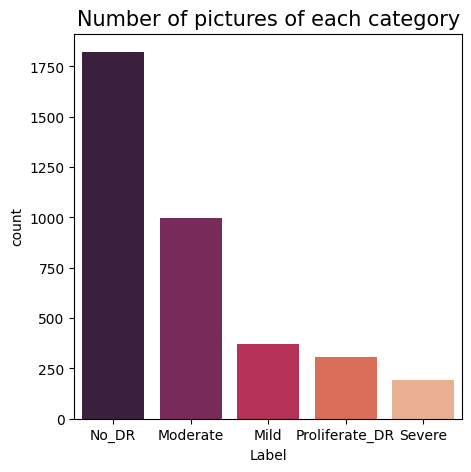

In [ ]:
count = image_df['Label'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x = count.index, y = count, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

3. Train, Test , Validate division of dataset

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

TRANSFER LEARNING

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Dictionary with the models
models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},

    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},

    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},

}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]


Found 2988 validated image filenames belonging to 5 classes.
Found 332 validated image filenames belonging to 5 classes.
Found 369 validated image filenames belonging to 5 classes.


67/94 [====================>.........] - ETA: 4:04 - loss: 0.8616 - accuracy: 0.6963

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0  DenseNet201          0.7088        0.7831              1003.65
1        VGG19          0.6509        0.6898                42.00
2     ResNet50          0.6442        0.6355                26.61

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

DENSENET201

In [ ]:
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
94/94 [==============================] - 35s 257ms/step - loss: 0.8038 - accuracy: 0.7229 - val_loss: 0.6812 - val_accuracy: 0.7319
Epoch 2/10
94/94 [==============================] - 21s 219ms/step - loss: 0.6397 - accuracy: 0.7677 - val_loss: 0.6332 - val_accuracy: 0.7831
Epoch 3/10
94/94 [==============================] - 20s 211ms/step - loss: 0.5926 - accuracy: 0.7798 - val_loss: 0.6464 - val_accuracy: 0.7530
Epoch 4/10
94/94 [==============================] - 21s 226ms/step - loss: 0.5558 - accuracy: 0.7885 - val_loss: 0.6721 - val_accuracy: 0.7590


In [ ]:
model.summary()

<Figure size 1200x400 with 0 Axes>

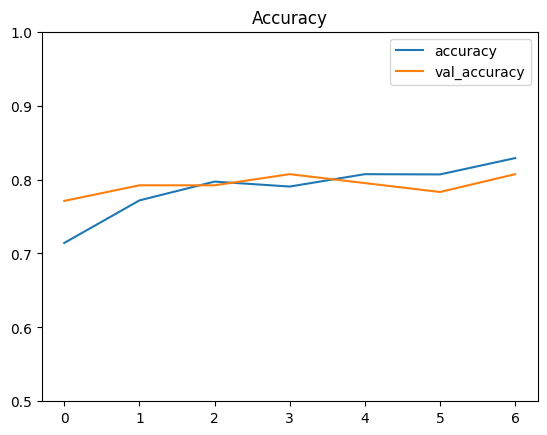

In [ ]:
plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.ylim([0.5,1])
plt.show()

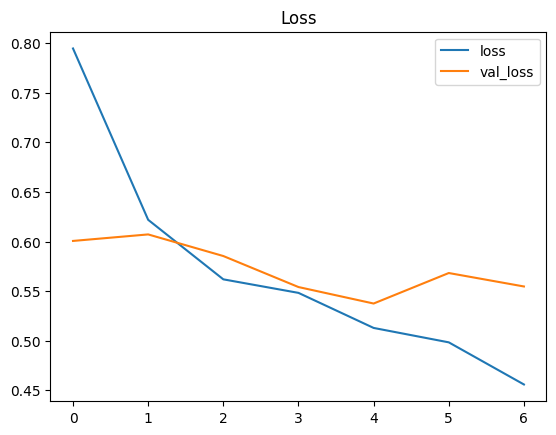

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Prediction on Test Dataset

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

12/12 [==============================] - 155s 14s/step
The first 5 predictions: ['Mild', 'No_DR', 'No_DR', 'Moderate', 'Moderate']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.50      0.31      0.38        32
      Moderate       0.59      0.94      0.73       101
         No_DR       0.95      0.93      0.94       181
Proliferate_DR       1.00      0.15      0.26        34
        Severe       0.80      0.19      0.31        21

      accuracy                           0.77       369
     macro avg       0.77      0.50      0.52       369
  weighted avg       0.81      0.77      0.73       369



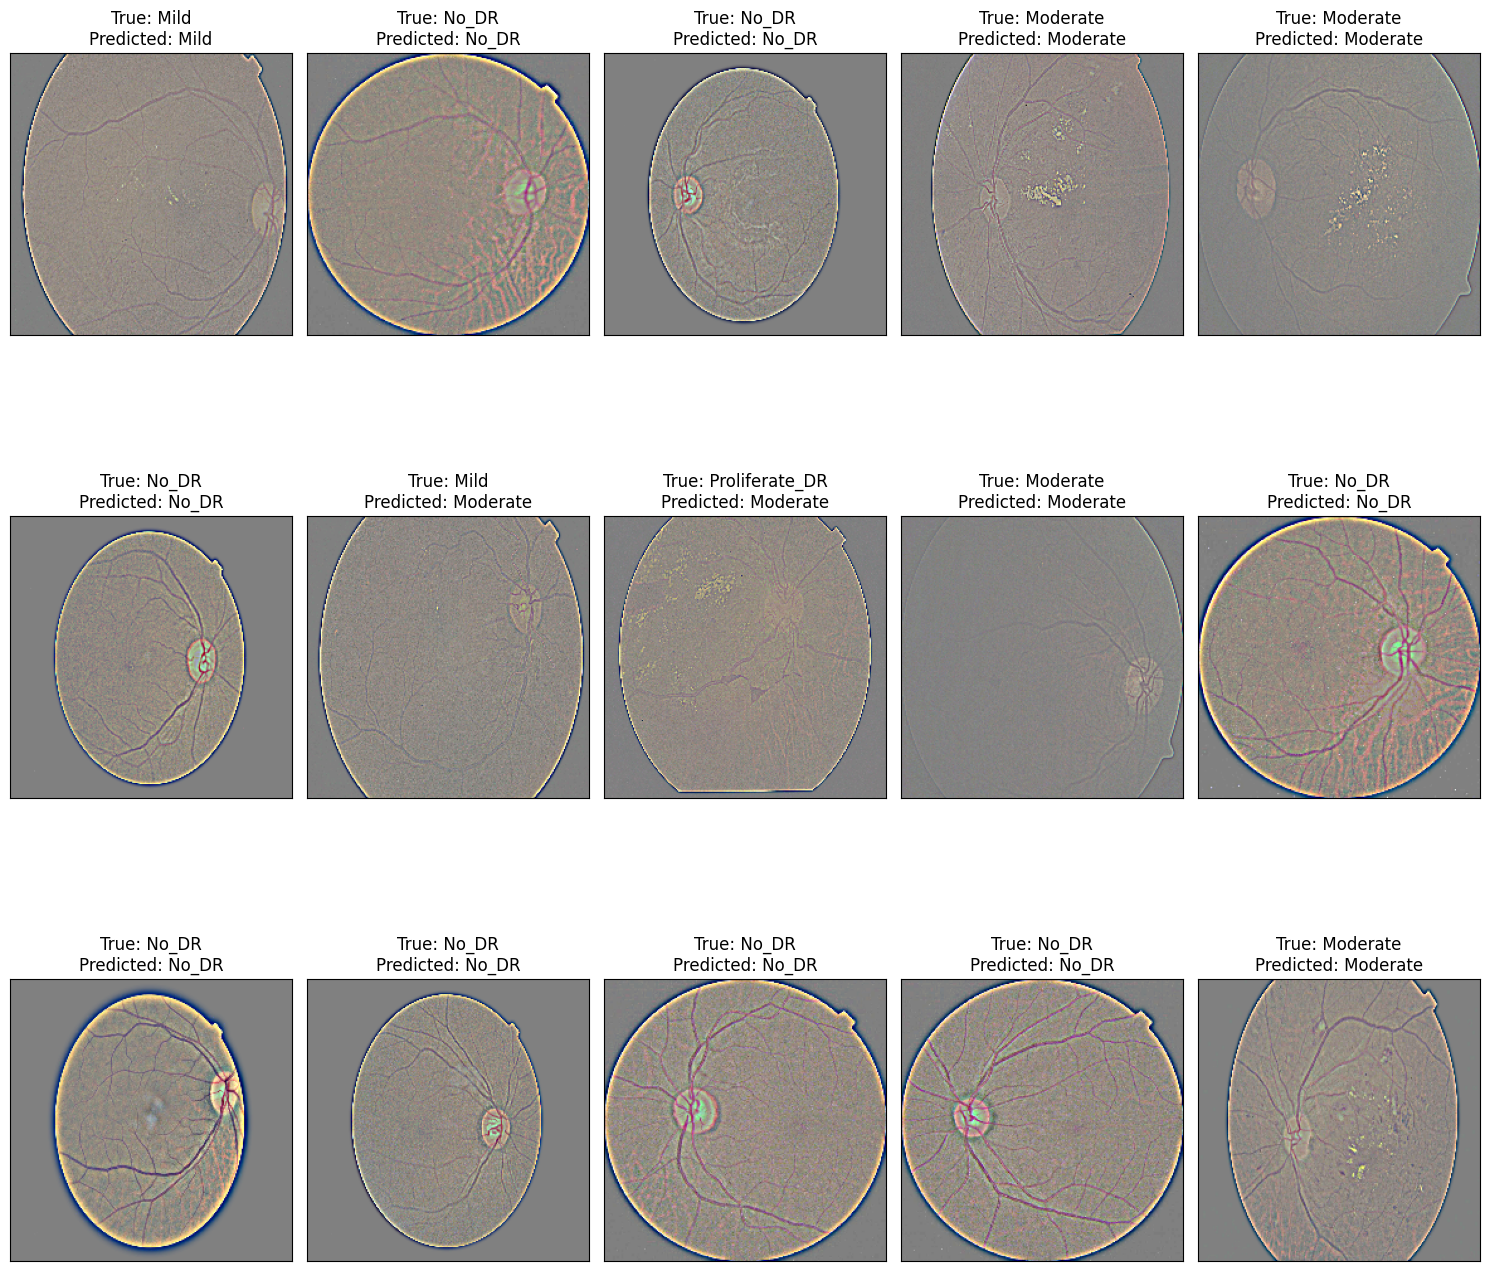

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Confusion Matrix

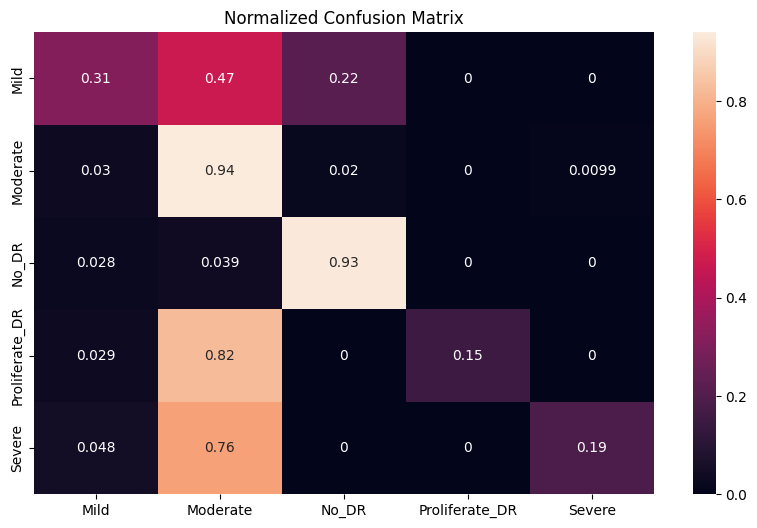

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()